In [1]:
!pip install torch
!pip install torchvision
!pip install Pillow==4.0.0
!pip install -U -q PyDrive

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a130000 @  0x7fbf897821c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 13.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 930kB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from zipfile import ZipFile
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
%matplotlib inline

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [43]:
listed = drive.ListFile().GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

title unet.ipynb, id 1n3H6UegwRTqJ_XBgX_Bp_bx2WQld9LHJ
title train _aug.zip, id 122ZmpdXDqWfEzY-zrLXSfyV3K8GTzZrt
title train.zip, id 1nJeSkGcVqeYD40rLyjlzCFBhFkmUmCSH
title Copy of unet.ipynb, id 1Tv6iyOSxD_wMLRYx7sldhiV5V9OTMeL-
title Copy of TGSSalt.ipynb, id 1jePVox0JDJumpGlCh1WbxCk9ce_DGlEH
title Copy of train.zip, id 1QMSqw4n2stvX0xevj9r1g68fQo1mUew2
title IMG_20180328_205506.jpg, id 1SFUq_0mfIkHGACtMDBx7DvDPiOZL1nrM
title IMG_20180329_185245.jpg, id 1t7las9Gymc8BvYmFjRgn_6F6xjXvu0D4
title North Kolkata Class Schedule, id 1yk7ky5KkQUe4av7IfPK4_8nlFsEYwcaC9gaxyB_aJnM
title kaggle_loan_model_with_oversampling.ipynb, id 1HsZjWSxhTscEi6HHpyhGa-1g0KHJnDzz
title home_credit.ipynb, id 10alOnjgNgjSiNWXACNdjlJfEBS9N9F3L
title model_test.ipynb, id 1Wfax5YDQRquKD1L-Z0a0LkRHhsZUuM8R
title Untitled, id 1X_E_O0q8K-9XZqWDtJ4N8bbdhoAamDCk
title store.h5, id 10gRxMCwcVHDVJr5PXAEDohOtlnGMacwq
title app_train_nlt60_cmt3_5_no_null_ef, id 1ffeOQb7yXJViZRkus0564jfFSihxNyqE
title Eligible Candidates Yo

In [0]:
downloaded = drive.CreateFile({'id': '1nJeSkGcVqeYD40rLyjlzCFBhFkmUmCSH'})
downloaded.GetContentFile('train.zip')
with ZipFile("train.zip", 'r') as z:
    z.extractall()
os.remove("train.zip")

In [0]:
class TGSSaltTrainDataset(Dataset):
    def __init__(self, image_dir,mask_dir,depth_csv,train_csv):
        self.image_dir=image_dir
        self.mask_dir=mask_dir
        
        depth=pd.read_csv(depth_csv)
        depth["z"]=(depth["z"]-depth["z"].min())/(depth["z"].max()-depth["z"].min())
        self.filter = np.array([(0,-1,-1,-1),(1,0,0,0),(1,0,1,0),(0,1,0,1)])/8
        self.input = pd.read_csv(train_csv)
        self.input.drop(['rle_mask'],axis=1,inplace=True)
        self.input = self.input.merge(depth,how="left",on="id")
        
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx,0]+".png")
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img1 = cv2.filter2D(img,-1,self.filter)
        
        sigma=0.33
        
        
        v = np.median(img1)

        #---- apply automatic Canny edge detection using the computed median----
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        img1 = cv2.Canny(img1, lower, upper)
        
        img2 = (cv2.Laplacian(img, cv2.CV_32F) + 127.0)
#         img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        
        img = torch.tensor(img).view(1,101,101).float()
        img1 = torch.tensor(img1).view(1,101,101).float()
        img2 = torch.tensor(img2).view(1,101,101)
        
        img = torch.cat((img,img1,img2),dim=0)/255
        
        mask_name = os.path.join(self.mask_dir,self.input.iloc[idx,0]+".png")
        mask = cv2.imread(mask_name)
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        mask = torch.tensor(mask).float()/255
        return img,mask

In [0]:
train_dataset = TGSSaltTrainDataset("images","masks","depths.csv","train.csv")

In [0]:
batch_size = 50
validation_split = 0.2
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=validation_sampler)

In [0]:
class BinaryCrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        """
        Binary cross entropy loss 2D
        Args:
            weight:
            size_average:
        """
        super(BinaryCrossEntropyLoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)
        if torch.cuda.is_available():
            self.bce_loss = self.bce_loss.cuda()

    def forward(self, pred, target):
        pred = F.sigmoid(pred)
        pred = pred.view(-1)  # Flatten
        target = target.view(-1)  # Flatten
        return self.bce_loss(pred, target)

In [0]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    def forward(self, pred, target):
        smooth = 1
        num = target.size(0)
        pred = F.sigmoid(pred)
        pred = pred.view(num, -1)
        target = target.view(num, -1)
        intersection = (pred * target)
        score = 2. * (intersection.sum(1) + smooth) / (pred.sum(1) + target.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [0]:
def dice_coeff(pred, target):
    smooth = 1.
    num = target.size(0)
    pred = pred.view(num, -1)  # Flatten
    target = target.view(num, -1)  # Flatten
    intersection = (pred * target)
    score = (2. * intersection.sum(1) + smooth).float() / (pred.sum(1) + target.sum(1) + smooth).float()
    return score.sum()/num

In [0]:
def bce_dice_loss(y_true, y_pred):
    return 0.5*BinaryCrossEntropyLoss2d()(y_true, y_pred)-dice_coeff(y_true, y_pred)

In [0]:
model=UNet(3,1)
criterion = bce_dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()

In [0]:
def validate(threshold):
    total_loss = 0
    accuracy = 0
    model.eval()
    for batch_idx, (data,target) in enumerate(validation_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        predict = (F.sigmoid(output) > threshold).float()
        # backward + optimize
        loss = criterion(output, target)
        # print statistics
        accuracy += dice_coeff(predict, target).item()
        total_loss+=loss.item()
    print('Validation Loss: {:.5f} Validation Accuracy: {:.5f}'.format(total_loss*batch_size/len(val_indices),accuracy*batch_size/len(val_indices)))

In [0]:
def train(threshold):
    epoch=1
    while True:
        total_loss = 0
        total_accuracy = 0
        model.train()
        exp_lr_scheduler.step()
        print(exp_lr_scheduler.get_lr())
        for batch_idx, (data,target) in enumerate(train_loader):
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            # forward
            output = model(data)
            predict = (F.sigmoid(output) > threshold).float()
            # backward + optimize
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print statistics
            accuracy = dice_coeff(predict, target)
            total_accuracy+=accuracy
            total_loss+=loss
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tAccuracy: {:.5f}'.format(epoch, (batch_idx + 1) * len(data), len(train_indices),100*(batch_idx + 1)* len(data) / len(train_indices), loss.item(),accuracy))
        print('Train Loss: {:.5f} Train Accuracy: {:.5f}'.format(total_loss.item()*batch_size/len(train_indices),total_accuracy.item()*batch_size/len(train_indices)))
        validate(threshold)
        epoch+=1

In [120]:
train(0.5)

Validation Loss: 0.61142 Validation Accuracy: 0.15460
[0.001]
Epoch: 7 [50/3200 (2%)]	Loss: 0.63193	Accuracy: 0.19432
Epoch: 7 [100/3200 (3%)]	Loss: 0.51910	Accuracy: 0.10746
Epoch: 7 [150/3200 (5%)]	Loss: 0.25582	Accuracy: 0.15993
Epoch: 7 [200/3200 (6%)]	Loss: 1.44138	Accuracy: 0.16917
Epoch: 7 [250/3200 (8%)]	Loss: 0.84509	Accuracy: 0.12000
Epoch: 7 [300/3200 (9%)]	Loss: 0.45357	Accuracy: 0.18520
Epoch: 7 [350/3200 (11%)]	Loss: 0.13541	Accuracy: 0.11208
Epoch: 7 [400/3200 (12%)]	Loss: 0.65504	Accuracy: 0.22222
Epoch: 7 [450/3200 (14%)]	Loss: 0.54437	Accuracy: 0.24683
Epoch: 7 [500/3200 (16%)]	Loss: 0.49771	Accuracy: 0.15738
Epoch: 7 [550/3200 (17%)]	Loss: 0.51667	Accuracy: 0.18522
Epoch: 7 [600/3200 (19%)]	Loss: 0.22483	Accuracy: 0.16905
Epoch: 7 [650/3200 (20%)]	Loss: 0.74490	Accuracy: 0.09793
Epoch: 7 [700/3200 (22%)]	Loss: 0.00864	Accuracy: 0.10547
Epoch: 7 [750/3200 (23%)]	Loss: 0.46322	Accuracy: 0.19956
Epoch: 7 [800/3200 (25%)]	Loss: 0.49390	Accuracy: 0.21987
Epoch: 7 [850/320

KeyboardInterrupt: ignored

torch.Size([3, 101, 101])
torch.Size([1, 101, 101])
torch.Size([101, 101])


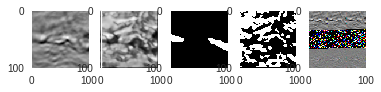

In [193]:
model.cpu()
fig, axeslist = plt.subplots(ncols=5,nrows=1)

x,y =train_dataset[100]
axeslist.ravel()[4].imshow(x.detach().numpy().reshape(101,101,3))
axeslist.ravel()[0].imshow(x.detach().numpy()[0],cmap='gray')
print(x.shape)
z = model(x.view(1,3,101,101))
axeslist.ravel()[1].imshow(z.squeeze(0).detach().numpy(),cmap='gray')
print(z.shape)
def getImg(x):
    x = x.view(1,3,101,101)
    x = model(x).detach().squeeze(0).numpy()[0]
    x = (x-x.mean()/(x.max()-x.min())) +1
    a = np.expand_dims(x, axis = 2)
    a = np.concatenate((a, a, a), axis = 2)
    return a
print(y.shape)
predict = (F.sigmoid(z) > 0.5).detach().numpy().squeeze(0)
axeslist.ravel()[3].imshow(predict,cmap='gray')


# axeslist.ravel()[1].imshow(getImg(y),cmap='gray')

axeslist.ravel()[2].imshow(y.detach().numpy(),cmap='gray')
plt.show()

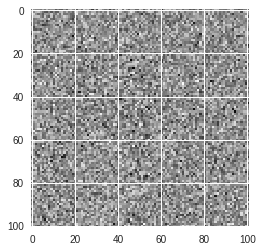

In [136]:
|x = torch.randn(1,3,101,101)
plt.imshow(x.numpy().squeeze(0)[0])

In [0]:
torch.save(model,'TGSUNetModel.pt')
uploaded = drive.CreateFile({'title': 'TGSUNetModel.pt'})
uploaded.SetContentFile('TGSUNetModel.pt')
uploaded.Upload()

In [0]:
downloaded = drive.CreateFile({'id': '14ivrIyqyeL5oFzQ-yLBN2F1JrSOeA-fY'})
downloaded.GetContentFile('test.zip')
with ZipFile("test.zip", 'r') as z:
  z.extractall()
os.remove("test.zip")

In [0]:
class TGSSaltTestDataset(Dataset):
    def __init__(self, image_dir,depth_csv,test_csv):
        self.image_dir=image_dir
        
        depth=pd.read_csv(depth_csv)
        depth["z"]=(depth["z"]-depth["z"].min())/(depth["z"].max()-depth["z"].min())
        
        self.input = pd.read_csv(test_csv)
        self.input = self.input.merge(depth,how="left",on="id")
        
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx,0]+".png")
        image = self.transform(Image.open(img_name))*self.input.iloc[idx,2]
        return image

In [0]:
test_dataset = TGSSaltTestDataset("test/images","depths.csv","test.csv")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
def predict():
    test_pred=torch.IntTensor(
    model.eval()
    for batch_idx, data in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        predict = (F.sigmoid(output) > threshold).int()
        test_pred=torch.cat((test_pred,pred.view(batch_size,101,101)),dim=0)
        return test_pred

In [0]:
predict=prediciton(test_loader)
predict=predict.cpu().numpy()

In [0]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
test_dataset.input.drop("z",axis=1,inplace=True)
for i in range(len(test_dataset)):
    test_dataset.input["rle_mask"][i]=rle_encode(predict[i])

In [0]:
test_dataset.input.to_csv("submission.csv",index=False)
uploaded = drive.CreateFile({'title': 'submission.csv'})
uploaded.SetContentFile('submission.csv')
uploaded.Upload()

from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True,up_size=None):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            if up_size:
                self.up = nn.Upsample(size= up_size, mode='bilinear', align_corners=True)
            else:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2 , int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256,up_size = (12,12))
        self.up2 = up(512, 128,up_size = (25,25))
        self.up3 = up(256, 64,up_size = (50,50))
        self.up4 = up(128, 64,up_size = (101,101))
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
#         print(x1.shape)
        x2 = self.down1(x1)
#         print(x2.shape)
        x3 = self.down2(x2)
#         print(x3.shape)
        x4 = self.down3(x3)
#         print(x4.shape)
        x5 = self.down4(x4)
#         print(x5.shape)
        x = self.up1(x5, x4)
#         print(x.shape)
        x = self.up2(x, x3)
#         print(x.shape)
        x = self.up3(x, x2)
#         print(x.shape)
        x = self.up4(x, x1)
#         print(x.shape)
        x = self.outc(x)
#         print(x.shape)
        return x.squeeze(1)

In [101]:
model = UNet(2,1)
x = torch.randn(10,2,101,101)
print(model(x).shape)

torch.Size([10, 101, 101])
